# **Skin Disease Classification Ensemble Model (ResNet + DenseNet)**

Install packages

In [1]:

!pip install torch torchvision tensorflow keras opencv-python scikit-learn matplotlib seaborn numpy pandas albumentations

Imports

In [2]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random
from tqdm import tqdm
from torchvision.datasets import ImageFolder
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive
import copy

SETUP

In [3]:
# Enable GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Mount Google Drive
drive.mount('/content/drive')

Using device: cuda
Mounted at /content/drive


# Define constants and hyperparameters

In [4]:
# config
TRAIN_DIR = "/content/drive/MyDrive/571/final project/train"
TEST_DIR = "/content/drive/MyDrive/571/final project/test"
class Config:
    # Dataset
    IMAGE_SIZE = 224
    HEIGHT = 224
    WIDTH  = 224
    TRAIN_DIR = "/content/drive/MyDrive/571/final project/train"
    TEST_DIR = "/content/drive/MyDrive/571/final project/test"

    MEAN = [0.485, 0.456, 0.406]
    STD  = [0.229, 0.224, 0.225]



    # Training
    BATCH_SIZE = 32
    LEARNING_RATE = 0.001
    FINE_TUNE_LR = 1e-4
    FROZEN_EPOCHS = 16
    FINE_TUNE_EPOCHS = 40 #early stopping will be impl

    # Model
    DROPOUT_RATE = 0.5
    NUM_CLASSES = 23

    # Early Stopping
    EARLY_STOPPING_PATIENCE = 4

config = Config()

train_dir = "/content/drive/MyDrive/571/final project/train"
test_dir = "/content/drive/MyDrive/571/final project/test"

# Print configuration
print("\n" + "="*60)
print("CONFIGURATION")
print("="*60)
print(f"Image Size: {config.IMAGE_SIZE}")
print(f"Batch Size: {config.BATCH_SIZE}")
print(f"Learning Rate: {config.LEARNING_RATE}")
print(f"Frozen Epochs: {config.FROZEN_EPOCHS}")
print(f"Fine-tune Epochs: {config.FINE_TUNE_EPOCHS}")
print(f"Number of Classes: {config.NUM_CLASSES}")
print("="*60)


CONFIGURATION
Image Size: 224
Batch Size: 32
Learning Rate: 0.001
Frozen Epochs: 16
Fine-tune Epochs: 40
Number of Classes: 23


Upload Dataset from Drive

In [5]:
import os

DATA_ROOT = "/content/data"

print("Data root exists:", os.path.exists(DATA_ROOT))
print("Train exists:", os.path.exists(f"{DATA_ROOT}/train"))
print("Test exists:", os.path.exists(f"{DATA_ROOT}/test"))

if os.path.exists(f"{DATA_ROOT}/train"):
    print("\nTrain classes:", os.listdir(f"{DATA_ROOT}/train"))

    total_train = sum(len(files) for _, _, files in os.walk(f"{DATA_ROOT}/train"))
    print("Total train images:", total_train)

if os.path.exists(f"{DATA_ROOT}/test"):
    total_test = sum(len(files) for _, _, files in os.walk(f"{DATA_ROOT}/test"))
    print("Total test images:", total_test)


Data root exists: False
Train exists: False
Test exists: False


# Data Augmentations

In [6]:

MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

class AlbumentationsTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, img):
        # Convert PIL Image to numpy array
        img = np.array(img)
        # Apply Albumentations transform
        img = self.transform(image=img)['image']
        return img



In [7]:

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

train_transform = A.Compose(
    transforms=[

        A.Resize(256, 256),
            #A.RandomResizedCrop(224, 224, scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=30, p=0.7),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0, rotate_limit=0, p=0.5),

            # Color transformations
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.HueSaturationValue(hue_shift_limit=0.1, sat_shift_limit=0.2, p=0.5),

            # select augmentations
            A.OneOf([
                A.MotionBlur(p=0.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.Blur(blur_limit=3, p=0.1),
            ], p=0.3),



        # Small rotations of ±15 degrees:
        A.Rotate(
            limit=(-15, 15),
            interpolation=cv2.INTER_AREA,
            border_mode=cv2.BORDER_CONSTANT,
            fill=0,
            p=0.5
        ),

        # Small shift to account for different scanning positions
        A.ShiftScaleRotate(
            shift_limit=0.05,
            scale_limit=0.05,
            rotate_limit=0,
            interpolation=cv2.INTER_AREA,
            border_mode=cv2.BORDER_CONSTANT,
            value=0,
            p=0.3
        ),



        A.OneOf([
            A.GaussNoise(std_range=(0.01, 0.03), mean_range=(0.0, 0.0), p=0.5),
            A.GaussianBlur(blur_limit=(3, 3), p=0.5),
        ], p=0.10),

        # Set size and normalize for ImageNet:
        A.Resize(height=224, width=224),

        #normalize
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)
train_transform = AlbumentationsTransform(train_transform)


val_transform = A.Compose(
    transforms=[
        A.Resize(height=224, width=224),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2(),
    ],
    p=1.0,
)
val_transform = AlbumentationsTransform(val_transform)






/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-2045424124.py:37: UserWarning: Argument(s) 'value' are not valid for transform ShiftScaleRotate
  A.ShiftScaleRotate(


Create datasets with augmentations

In [8]:
# datasets
def create_datasets(train_dir, test_dir):
    print("loading datasets..")

    # Load datasets using the globally defined transforms
    train_dataset = ImageFolder(TRAIN_DIR, transform= train_transform)
    test_dataset = ImageFolder(TEST_DIR, transform= val_transform)

    # Update number of classes based on actual dataset
    global config # Ensure config is recognized as global
    config.NUM_CLASSES = len(train_dataset.classes)

    print(f"Number of classes: {config.NUM_CLASSES}")
    print(f"Class names: {train_dataset.classes}")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    # Split train into train and validation
    train_size = int(0.8 * len(train_dataset))
    val_size = len(train_dataset) - train_size

    train_subset, val_dataset = random_split(
        train_dataset, [train_size, val_size],
        generator=torch.Generator().manual_seed(42)
    )

    print(f"\nAfter splitting:")
    print(f"Training samples: {len(train_subset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return train_subset, val_dataset, test_dataset, train_dataset.classes # Return class_names as well

# Call create_datasets
train_subset, val_dataset, test_dataset, class_names = create_datasets(config.TRAIN_DIR, config.TEST_DIR)
print(f"\nConfirm same as above: splitting:")
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


loading datasets..
Number of classes: 23
Class names: ['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Bullous Disease Photos', 'Cellulitis Impetigo and other Bacterial Infections', 'Eczema Photos', 'Exanthems and Drug Eruptions', 'Hair Loss Photos Alopecia and other Hair Diseases', 'Herpes HPV and other STDs Photos', 'Light Diseases and Disorders of Pigmentation', 'Lupus and other Connective Tissue diseases', 'Melanoma Skin Cancer Nevi and Moles', 'Nail Fungus and other Nail Disease', 'Poison Ivy Photos and other Contact Dermatitis', 'Psoriasis pictures Lichen Planus and related diseases', 'Scabies Lyme Disease and other Infestations and Bites', 'Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Urticaria Hives', 'Vascular Tumors', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections']
Train samples: 15557
Test samples: 4

visualize samples

In [9]:
def denormalize(img, mean, std):
    """
    Undo normalization for visualization.

    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean


In [10]:
import random
import matplotlib.pyplot as plt

#denormalize
MEAN = [0.485, 0.456, 0.406]
STD  = [0.229, 0.224, 0.225]

def denormalize(img, mean=MEAN, std=STD):
    mean = torch.tensor(mean).view(3,1,1)
    std  = torch.tensor(std).view(3,1,1)
    return img * std + mean

#visualize func
def visualize_train_samples(dataset, class_names, num_samples):

  indices = random.sample(range(len(dataset)), num_samples)

  plt.figure(figsize=(16, 6))

  for i, idx in enumerate(indices):
        img, label = train_subset[idx]

        # Undo normalization for display
        img = denormalize(img).clamp(0, 1)
        img = img.permute(1, 2, 0)          #

        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(class_names[label], fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

def visualize_val_samples(dataset, class_names, num_samples):

  indices = random.sample(range(len(dataset)), num_samples)

  plt.figure(figsize=(16, 6))

  for i, idx in enumerate(indices):
        img, label = val_dataset[idx]

        # Undo normalization for display
        img = denormalize(img).clamp(0, 1)
        img = img.permute(1, 2, 0)

        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(class_names[label], fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()

def visualize_test_samples(dataset, class_names, num_samples):

  indices = random.sample(range(len(dataset)), num_samples)

  plt.figure(figsize=(16, 6))

  for i, idx in enumerate(indices):
        img, label = test_dataset[idx]

        # Undo normalization for display
        img = denormalize(img).clamp(0, 1)
        img = img.permute(1, 2, 0)

        plt.subplot(2, (num_samples + 1) // 2, i + 1)
        plt.imshow(img)
        plt.title(class_names[label], fontsize=12)
        plt.axis("off")
        plt.tight_layout()
        plt.show()







Training Sample Images


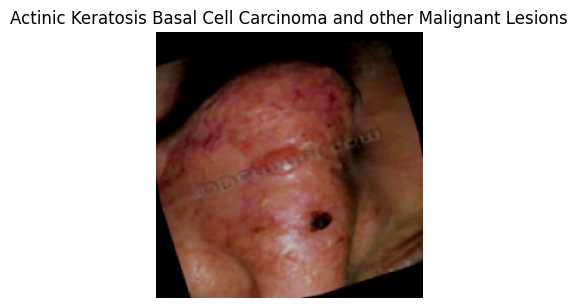

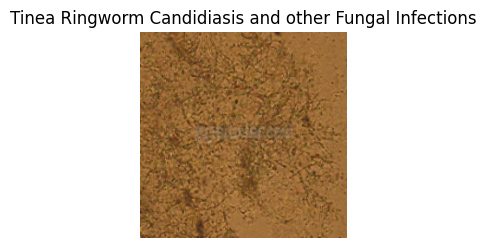

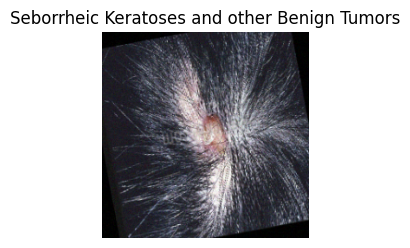

 Validation Sample Images


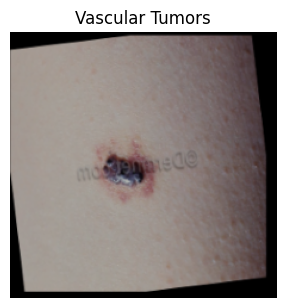

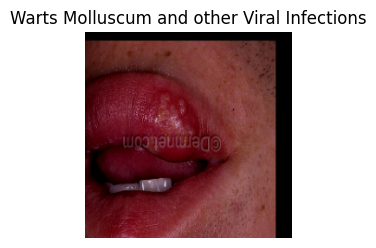

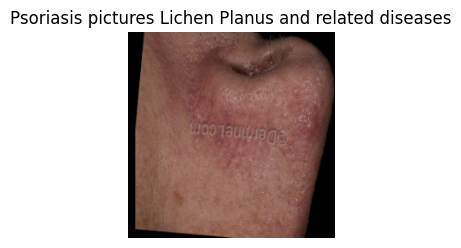

 Test Sample Images


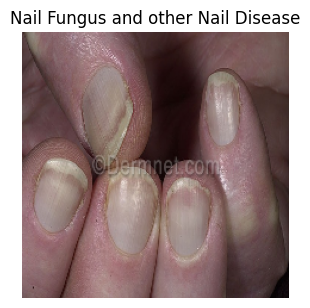

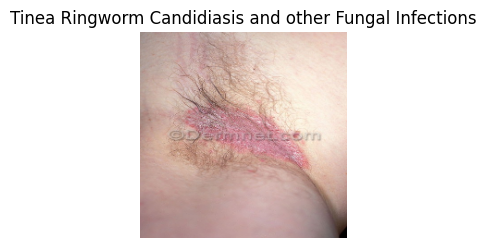

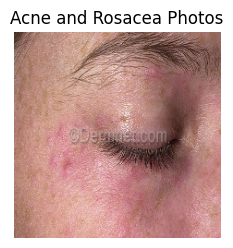

In [11]:
print(f"Training Sample Images")
visualize_train_samples(train_subset, class_names, 3)
print(f" Validation Sample Images")
visualize_val_samples(val_dataset, class_names, 3)
print(f" Test Sample Images")
visualize_test_samples(test_dataset, class_names, 3)



Create dataloaders

In [12]:

def create_dataloaders(train_dataset, val_dataset, test_dataset):
  #dataloaders for trainign



    # Create dataloaders
    train_loader = DataLoader(train_dataset,batch_size=config.BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)

    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False, #no need
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"\nDataloader Information:")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Test batches: {len(test_loader)}")

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = create_dataloaders(train_subset, val_dataset, test_dataset)





Dataloader Information:
Training batches: 389
Validation batches: 98
Test batches: 126


In [13]:
# Enable GPU again
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [19]:
import torch
from torch.utils.data import Subset

def get_labels_from_dataset(ds):

    # If it's a Subset, unwrap it
    if isinstance(ds, Subset):
        base = ds.dataset
        idxs = ds.indices

        # Get labels from base dataset
        if hasattr(base, "targets"):
            base_labels = base.targets
        elif hasattr(base, "samples"):
            base_labels = [s[1] for s in base.samples]
        else:
            raise ValueError("Base dataset does not expose labels via targets/samples")

        # Select only subset labels
        return [base_labels[i] for i in idxs]

    # Non-subset datasets
    if hasattr(ds, "targets"):
        return ds.targets
    if hasattr(ds, "samples"):
        return [s[1] for s in ds.samples]

    raise ValueError("Dataset does not expose labels directly")

def calculate_class_weights_fast(dataset, num_classes, device="cuda"):
    labels = get_labels_from_dataset(dataset)
    labels = torch.tensor(labels, dtype=torch.long)

    class_counts = torch.bincount(labels, minlength=num_classes).float()
    class_counts[class_counts == 0] = 1  # avoid divide-by-zero

    total = class_counts.sum()
    class_weights = total / (num_classes * class_counts)
    class_weights = class_weights / class_weights.sum()

    print("\nClass weights calculated:")
    for i, w in enumerate(class_weights):
        print(f" Class {i}: {w:.4f}")

    return class_weights.to(device)


In [20]:
print(type(train_subset))
print("Base dataset:", type(train_subset.dataset))
print("Num subset samples:", len(train_subset))
class_weights = calculate_class_weights_fast(train_subset, config.NUM_CLASSES, device=device)


<class 'torch.utils.data.dataset.Subset'>
Base dataset: <class 'torchvision.datasets.folder.ImageFolder'>
Num subset samples: 12445

Class weights calculated:
 Class 0: 0.0254
 Class 1: 0.0185
 Class 2: 0.0437
 Class 3: 0.0485
 Class 4: 0.0735
 Class 5: 0.0175
 Class 6: 0.0525
 Class 7: 0.0866
 Class 8: 0.0536
 Class 9: 0.0380
 Class 10: 0.0509
 Class 11: 0.0474
 Class 12: 0.0204
 Class 13: 0.0808
 Class 14: 0.0149
 Class 15: 0.0492
 Class 16: 0.0156
 Class 17: 0.0356
 Class 18: 0.0163
 Class 19: 0.0969
 Class 20: 0.0437
 Class 21: 0.0505
 Class 22: 0.0199


# Build Ensemble model architecture

In [21]:
class EnsembleModel(nn.Module):
    def __init__(self, num_classes=config.NUM_CLASSES, dropout_rate=config.DROPOUT_RATE, hidden_features=256):
        super().__init__()

        self.num_classes = num_classes
        self.hidden_features = hidden_features

        print(f"Initializing Ensemble Model with:")
        print(f"- Num classes: {num_classes}")
        print(f"- Dropout rate: {dropout_rate}")

        # Load pretrained models resent and densenet
        # Backbones
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.densenet = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

        # Get number of features from each model
        num_features_resnet = self.resnet.fc.in_features
        num_features_densenet = self.densenet.classifier.in_features

        print(f"ResNet features: {num_features_resnet}")
        print(f"DenseNet features: {num_features_densenet}")

        # Replace classifier heads with dropout
        self.resnet.fc = self._create_classifier_head(num_features_resnet, 256, dropout_rate, hidden_features)
        self.densenet.classifier = self._create_classifier_head(num_features_densenet, 256, dropout_rate, hidden_features)

        # Final classifier: (256 + 256) num_classes
        self.combined_classifier = self._create_classifier_head(
             in_features=512, out_features=num_classes, dropout_rate=dropout_rate, hidden_features=hidden_features
         )


        # Combined classifier with dropout
        combined_features = 512  # 256 from each model
        #actual_combined_features = torch.cat((num_features_resnet, num_features_densenet), dim=1)

        print(f"does output layers = combined head layers?: {hidden_features * 2 == combined_features}")



        # Count parameters
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")


    def _create_classifier_head(self, in_features, out_features, dropout_rate, hidden_features):

        layers = [
            nn.Dropout(dropout_rate),
            nn.Linear(in_features, hidden_features),
            nn.BatchNorm1d(hidden_features),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(hidden_features, hidden_features // 2),
            nn.ReLU(),
            nn.Linear(hidden_features // 2, hidden_features // 4),
            nn.ReLU(),
             nn.Linear(hidden_features // 4, out_features)

        ]

        return nn.Sequential(*layers)

    def forward(self, x):
        features_resnet = self.resnet(x)
        features_densenet = self.densenet(x)
        combined_layers = torch.cat((features_resnet, features_densenet), dim=1)
        output = self.combined_classifier(combined_layers)
        return output

# Create model
model = EnsembleModel(num_classes=config.NUM_CLASSES,
                      dropout_rate=config.DROPOUT_RATE,
                      hidden_features=256)
model = model.to(device)

print(f"\nModel created")

# Loss function
#use this one when weight adjustement for underrepresented classes, block of code done running
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"\nUsing class-weighted CrossEntropyLoss")

#criterion = nn.CrossEntropyLoss()






Initializing Ensemble Model with:
- Num classes: 23
- Dropout rate: 0.5
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 191MB/s]


ResNet features: 2048
DenseNet features: 1024
does output layers = combined head layers?: True
Total parameters: 31,539,927
Trainable parameters: 31,539,927

Model created

Using class-weighted CrossEntropyLoss


freeze func

In [22]:

def freeze_backbone(model):
    """Freeze backbone layers, keep classifier head trainable"""
    print("\nFreezing backbone layers...")

    # Freeze ResNet
    for param in model.resnet.parameters():
        param.requires_grad = False

    # Freeze DenseNet
    for param in model.densenet.parameters():
        param.requires_grad = False

    # Keep classifier trainable
    for param in model.resnet.fc.parameters():
        param.requires_grad = True
    for param in model.densenet.classifier.parameters():
        param.requires_grad = True
    for param in model.combined_classifier.parameters():
        param.requires_grad = True

    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters after freezing: {trainable_params:,}")

    return model

unfreeze/fine tune

In [23]:
def unfreeze_restnet_for_finetuning(model, num_layers=4):
        """Unfreeze deeper layers for fine-tuning """

        print(f"\nUnfreezing last {num_layers} layers for fine-tuning...")

        # Unfreeze last N layers of ResNet
        resnet_layers = list(model.resnet.children())
        for layer in resnet_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True




        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters after unfreezing resnet: {trainable_params:,}")

        return model

def unfreeze_densenet_for_finetuning(model, num_layers=4):
        """Unfreeze deeper layers for fine-tuning """

        print(f"\nUnfreezing last {num_layers} layers for fine-tuning...")



        # Unfreeze last num_layers of DenseNet
        densenet_layers = list(model.densenet.children())
        for layer in densenet_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True


        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters after unfreezing densenet: {trainable_params:,}")

        return model

def unfreeze_for_finetuning(model, num_layers=4):
        """Unfreeze deeper layers for fine-tuning """

        print(f"\nUnfreezing last {num_layers} layers for fine-tuning...")

         # Unfreeze last N layers of ResNet
        resnet_layers = list(model.resnet.children())
        for layer in resnet_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True




        # Unfreeze last num_layers of DenseNet
        densenet_layers = list(model.densenet.children())
        for layer in densenet_layers[-num_layers:]:
            for param in layer.parameters():
                param.requires_grad = True


        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print(f"Trainable parameters after unfreezing densenet: {trainable_params:,}")

        return model





# Training and Evaluation

Train Epoch Function

In [24]:

def train_epoch(model, dataloader, criterion, optimizer, device, phase='training'):
    #train for one epoch
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc=f"Training ({phase})"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc



Validate Epoch Function

In [25]:
def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc, all_preds, all_labels


# Train Models




Training viuslaization helper

In [26]:
def plot_training_history(train_losses, val_losses, train_accs, val_accs, phase):
    """Plot training history for a phase"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss plot
    epochs = range(1, len(train_losses) + 1)
    ax1.plot(epochs, train_losses, 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Val Loss', linewidth=2)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{phase} - Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Accuracy plot
    ax2.plot(epochs, train_accs, 'b-', label='Train Acc', linewidth=2)
    ax2.plot(epochs, val_accs, 'r-', label='Val Acc', linewidth=2)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{phase} - Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Training History - {phase} Phase', fontsize=14)
    plt.tight_layout()
    plt.show()

In [27]:
##>?????/

train frozen backbone

In [33]:
import torch
print(torch.cuda.get_device_name(0))


NVIDIA A100-SXM4-80GB


# Train and Eval Model with frozen backbone and only trainable Classifier Heads


Freezing backbone layers...
Trainable parameters after freezing: 1,078,039
Done freezing backbone. Trainable params: 1,078,039 / 31,539,927

PHASE 1: TRAINING FROZEN BACKBONE

Epoch 1/16
----------------------------------------


Validation: 100%|██████████| 98/98 [13:11<00:00,  8.08s/it]


Train Loss: 2.8542 | Train Acc: 14.78%
Val Loss: 2.7079 | Val Acc: 17.38%
Learning Rate: 0.001000
Saved best frozen model (Acc: 17.38%)

Epoch 2/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]


Train Loss: 2.7637 | Train Acc: 17.89%
Val Loss: 2.6342 | Val Acc: 20.40%
Learning Rate: 0.001000
Saved best frozen model (Acc: 20.40%)

Epoch 3/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  6.02it/s]


Train Loss: 2.7119 | Train Acc: 19.71%
Val Loss: 2.6025 | Val Acc: 21.92%
Learning Rate: 0.001000
Saved best frozen model (Acc: 21.92%)

Epoch 4/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]


Train Loss: 2.6854 | Train Acc: 20.96%
Val Loss: 2.5760 | Val Acc: 23.20%
Learning Rate: 0.001000
Saved best frozen model (Acc: 23.20%)

Epoch 5/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]


Train Loss: 2.6625 | Train Acc: 21.27%
Val Loss: 2.5141 | Val Acc: 26.06%
Learning Rate: 0.001000
Saved best frozen model (Acc: 26.06%)

Epoch 6/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:17<00:00,  5.74it/s]


Train Loss: 2.6177 | Train Acc: 22.64%
Val Loss: 2.4825 | Val Acc: 25.93%
Learning Rate: 0.001000

Epoch 7/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s]


Train Loss: 2.6081 | Train Acc: 22.84%
Val Loss: 2.4620 | Val Acc: 26.32%
Learning Rate: 0.001000
Saved best frozen model (Acc: 26.32%)

Epoch 8/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]


Train Loss: 2.5995 | Train Acc: 23.28%
Val Loss: 2.4979 | Val Acc: 26.06%
Learning Rate: 0.001000

Epoch 9/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]


Train Loss: 2.5658 | Train Acc: 23.46%
Val Loss: 2.4545 | Val Acc: 26.54%
Learning Rate: 0.001000
Saved best frozen model (Acc: 26.54%)

Epoch 10/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]


Train Loss: 2.5549 | Train Acc: 23.71%
Val Loss: 2.4377 | Val Acc: 28.28%
Learning Rate: 0.001000
Saved best frozen model (Acc: 28.28%)

Epoch 11/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]


Train Loss: 2.5407 | Train Acc: 23.87%
Val Loss: 2.4262 | Val Acc: 27.15%
Learning Rate: 0.001000

Epoch 12/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]


Train Loss: 2.5231 | Train Acc: 24.19%
Val Loss: 2.3897 | Val Acc: 27.54%
Learning Rate: 0.001000

Epoch 13/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.93it/s]


Train Loss: 2.5169 | Train Acc: 24.42%
Val Loss: 2.3599 | Val Acc: 28.95%
Learning Rate: 0.001000
Saved best frozen model (Acc: 28.95%)

Epoch 14/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]


Train Loss: 2.5150 | Train Acc: 24.23%
Val Loss: 2.3605 | Val Acc: 28.57%
Learning Rate: 0.001000

Epoch 15/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]


Train Loss: 2.4904 | Train Acc: 24.98%
Val Loss: 2.3658 | Val Acc: 28.50%
Learning Rate: 0.001000

Epoch 16/16
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]


Train Loss: 2.4868 | Train Acc: 25.01%
Val Loss: 2.3606 | Val Acc: 29.08%
Learning Rate: 0.001000
Saved best frozen model (Acc: 29.08%)


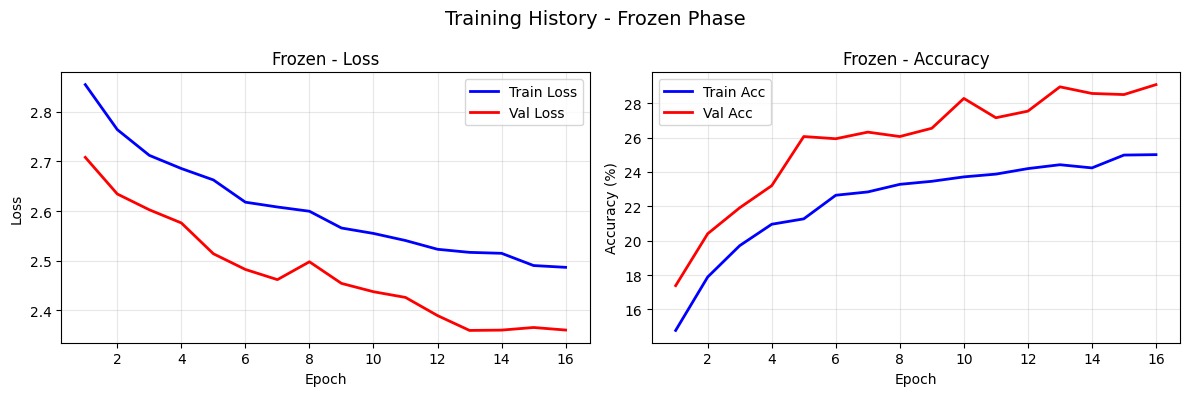

In [32]:
# Freeze backbone initially
model = freeze_backbone(model)
# sanity check
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Done freezing backbone. Trainable params: {trainable:,} / {total:,}")


# TRAIN FROZEN BACKBONE
def train_frozen_backbone(model, train_loader, val_loader, criterion, num_epochs=config.FROZEN_EPOCHS):
    """Train model with frozen backbone"""
    print("\n" + "="*60)
    print("PHASE 1: TRAINING FROZEN BACKBONE")
    print("="*60)

    # Optimizer for classifier only
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config.LEARNING_RATE
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )

    # Track history
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    #starting vals
    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Train use train function
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, 'frozen')
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate use validation function
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update scheduler
        scheduler.step(val_loss)

        # Print results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_frozen_model.pth')
            print(f"Saved best frozen model (Acc: {val_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= config.EARLY_STOPPING_PATIENCE:
            print(f"\n Early stopping at epoch {epoch+1}")
            break

    # Plot results
    plot_training_history(train_losses, val_losses, train_accs, val_accs, "Frozen")

    return model, best_val_acc

# Train frozen backbone
model, frozen_best_acc = train_frozen_backbone(model, train_loader, val_loader, criterion)

# Train and Eval Model with frozen backbone and trainable Layers and Classifier Heads


Unfreezing last 4 layers for fine-tuning...
Trainable parameters after unfreezing densenet: 30,094,999
Done unfreezing layers. Trainable params: 30,094,999 / 31,539,927

PHASE 2: FINE-TUNING UNFROZEN LAYERS

Unfreezing last 4 layers for fine-tuning...
Trainable parameters after unfreezing densenet: 30,094,999

Epoch 1/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]


Train Loss: 2.3873 | Train Acc: 28.06%
Val Loss: 2.2423 | Val Acc: 31.88%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 1 (Acc: 31.88%)

Epoch 2/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s]


Train Loss: 2.2585 | Train Acc: 31.57%
Val Loss: 2.1690 | Val Acc: 34.16%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 2 (Acc: 34.16%)

Epoch 3/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  6.11it/s]


Train Loss: 2.1596 | Train Acc: 33.48%
Val Loss: 2.1019 | Val Acc: 35.89%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 3 (Acc: 35.89%)

Epoch 4/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]


Train Loss: 2.0731 | Train Acc: 35.92%
Val Loss: 2.0821 | Val Acc: 37.05%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 4 (Acc: 37.05%)

Epoch 5/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]


Train Loss: 1.9966 | Train Acc: 37.04%
Val Loss: 2.0155 | Val Acc: 37.34%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 5 (Acc: 37.34%)

Epoch 6/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]


Train Loss: 1.9285 | Train Acc: 38.64%
Val Loss: 2.0105 | Val Acc: 38.27%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 6 (Acc: 38.27%)

Epoch 7/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  6.00it/s]


Train Loss: 1.8693 | Train Acc: 40.14%
Val Loss: 1.9721 | Val Acc: 39.88%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 7 (Acc: 39.88%)

Epoch 8/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]


Train Loss: 1.7996 | Train Acc: 42.37%
Val Loss: 1.9699 | Val Acc: 40.30%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 8 (Acc: 40.30%)

Epoch 9/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]


Train Loss: 1.7397 | Train Acc: 43.07%
Val Loss: 1.9558 | Val Acc: 41.68%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 9 (Acc: 41.68%)

Epoch 10/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.86it/s]


Train Loss: 1.6658 | Train Acc: 44.97%
Val Loss: 1.9187 | Val Acc: 42.29%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 10 (Acc: 42.29%)

Epoch 11/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]


Train Loss: 1.6035 | Train Acc: 46.44%
Val Loss: 1.9074 | Val Acc: 41.84%
Learning Rate: 0.000100

Epoch 12/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.84it/s]


Train Loss: 1.5390 | Train Acc: 48.28%
Val Loss: 1.9047 | Val Acc: 45.31%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 12 (Acc: 45.31%)

Epoch 13/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  6.01it/s]


Train Loss: 1.4905 | Train Acc: 50.01%
Val Loss: 1.9029 | Val Acc: 43.93%
Learning Rate: 0.000100

Epoch 14/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.96it/s]


Train Loss: 1.4207 | Train Acc: 50.97%
Val Loss: 1.8856 | Val Acc: 45.73%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 14 (Acc: 45.73%)

Epoch 15/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]


Train Loss: 1.3838 | Train Acc: 52.56%
Val Loss: 1.8859 | Val Acc: 45.89%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 15 (Acc: 45.89%)

Epoch 16/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s]


Train Loss: 1.2893 | Train Acc: 54.37%
Val Loss: 1.9334 | Val Acc: 46.66%
Learning Rate: 0.000100
 Saved best fine-tuned model at epoch 16 (Acc: 46.66%)

Epoch 17/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]


Train Loss: 1.2555 | Train Acc: 55.81%
Val Loss: 1.9492 | Val Acc: 44.83%
Learning Rate: 0.000100

Epoch 18/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s]


Train Loss: 1.2352 | Train Acc: 56.19%
Val Loss: 1.8922 | Val Acc: 47.65%
Learning Rate: 0.000050
 Saved best fine-tuned model at epoch 18 (Acc: 47.65%)

Epoch 19/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  6.07it/s]


Train Loss: 1.0595 | Train Acc: 61.01%
Val Loss: 1.8002 | Val Acc: 49.81%
Learning Rate: 0.000050
 Saved best fine-tuned model at epoch 19 (Acc: 49.81%)

Epoch 20/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.85it/s]


Train Loss: 0.9793 | Train Acc: 62.85%
Val Loss: 1.8248 | Val Acc: 50.93%
Learning Rate: 0.000050
 Saved best fine-tuned model at epoch 20 (Acc: 50.93%)

Epoch 21/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]


Train Loss: 0.9284 | Train Acc: 64.86%
Val Loss: 1.8693 | Val Acc: 50.96%
Learning Rate: 0.000050
 Saved best fine-tuned model at epoch 21 (Acc: 50.96%)

Epoch 22/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]


Train Loss: 0.8751 | Train Acc: 66.24%
Val Loss: 1.9332 | Val Acc: 52.02%
Learning Rate: 0.000050
 Saved best fine-tuned model at epoch 22 (Acc: 52.02%)

Epoch 23/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:17<00:00,  5.72it/s]


Train Loss: 0.8343 | Train Acc: 67.55%
Val Loss: 1.8937 | Val Acc: 52.38%
Learning Rate: 0.000025
 Saved best fine-tuned model at epoch 23 (Acc: 52.38%)

Epoch 24/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.79it/s]


Train Loss: 0.7926 | Train Acc: 69.45%
Val Loss: 1.8628 | Val Acc: 54.15%
Learning Rate: 0.000025
 Saved best fine-tuned model at epoch 24 (Acc: 54.15%)

Epoch 25/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  6.02it/s]


Train Loss: 0.7377 | Train Acc: 70.75%
Val Loss: 1.8650 | Val Acc: 53.60%
Learning Rate: 0.000025

Epoch 26/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]


Train Loss: 0.6806 | Train Acc: 72.30%
Val Loss: 1.9163 | Val Acc: 54.31%
Learning Rate: 0.000025
 Saved best fine-tuned model at epoch 26 (Acc: 54.31%)

Epoch 27/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]


Train Loss: 0.6853 | Train Acc: 72.57%
Val Loss: 1.9205 | Val Acc: 54.08%
Learning Rate: 0.000013

Epoch 28/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.99it/s]


Train Loss: 0.6400 | Train Acc: 74.00%
Val Loss: 1.9461 | Val Acc: 54.76%
Learning Rate: 0.000013
 Saved best fine-tuned model at epoch 28 (Acc: 54.76%)

Epoch 29/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]


Train Loss: 0.6118 | Train Acc: 74.69%
Val Loss: 1.8935 | Val Acc: 55.37%
Learning Rate: 0.000013
 Saved best fine-tuned model at epoch 29 (Acc: 55.37%)

Epoch 30/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]


Train Loss: 0.6078 | Train Acc: 75.33%
Val Loss: 1.9450 | Val Acc: 55.30%
Learning Rate: 0.000013

Epoch 31/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.97it/s]


Train Loss: 0.5841 | Train Acc: 75.57%
Val Loss: 1.9335 | Val Acc: 55.04%
Learning Rate: 0.000006

Epoch 32/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]


Train Loss: 0.5616 | Train Acc: 76.42%
Val Loss: 1.9299 | Val Acc: 55.27%
Learning Rate: 0.000006

Epoch 33/40
----------------------------------------


Validation: 100%|██████████| 98/98 [00:16<00:00,  5.98it/s]


Train Loss: 0.5567 | Train Acc: 76.45%
Val Loss: 1.9397 | Val Acc: 55.33%
Learning Rate: 0.000006

 Early stopping at epoch 33


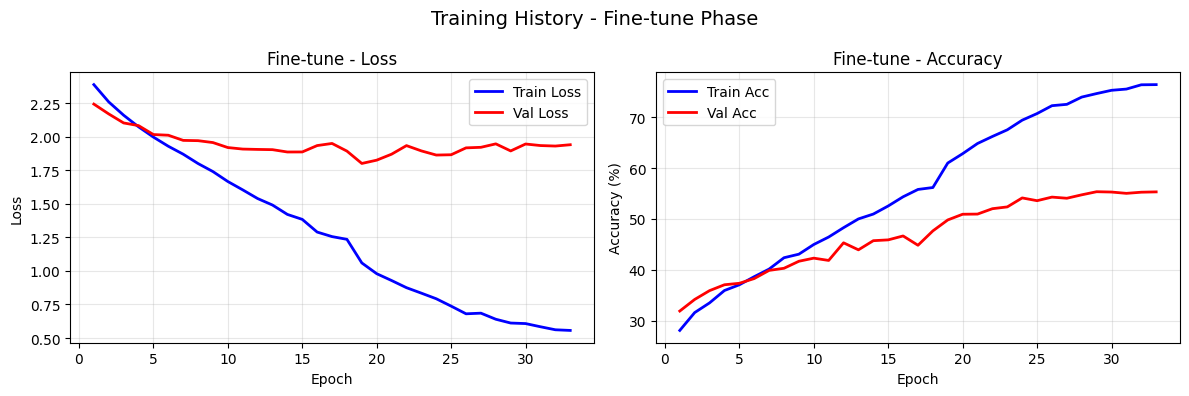

Best fine-tuned val acc: 55.36632390745501


In [34]:
# unfreeze layers initially
model = unfreeze_for_finetuning(model, num_layers=4)

#sanity check
trainable2 = sum(p.numel() for p in model.parameters() if p.requires_grad)
total2 = sum(p.numel() for p in model.parameters())
print(f"Done unfreezing layers. Trainable params: {trainable2:,} / {total2:,}")


# FINE-TUNE UNFROZEN MODEL
def fine_tune_model(model, train_loader, val_loader, criterion, num_epochs=config.FINE_TUNE_EPOCHS):
    """Fine-tune model with unfrozen layers"""
    print("\n" + "="*60)
    print("PHASE 2: FINE-TUNING UNFROZEN LAYERS")
    print("="*60)

    # Unfreeze for fine-tuning
    model = unfreeze_for_finetuning(model, num_layers=4)

    # Optimizer for all trainable parameters
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config.FINE_TUNE_LR
    )

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3    )

    # Track history
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0
    best_state = copy.deepcopy(model.state_dict())
    best_epoch = -1
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 40)

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, 'fine-tune')
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validate
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update scheduler
        scheduler.step(val_loss)

        # Print results
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
            torch.save({
                'epoch': epoch,
                'model_state_dict': best_state,
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_finetuned_model.pth')
            print(f" Saved best fine-tuned model at epoch {epoch+1} (Acc: {val_acc:.2f}%)")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= config.EARLY_STOPPING_PATIENCE:
            print(f"\n Early stopping at epoch {epoch+1}")
            break

    #load model with best saved state before returning
    model.load_state_dict(best_state)

    # Plot results
    plot_training_history(train_losses, val_losses, train_accs, val_accs, "Fine-tune")

    return model, best_val_acc

#for using when reconnecting code
# ? torch.save({'model_state_dict': best_state, ...}, 'best_finetuned_model.pth')


# Fine-tune model
best_model, finetuned_best_acc = fine_tune_model(model, train_loader, val_loader, criterion)
print("Best fine-tuned val acc:", finetuned_best_acc)


In [35]:
"""
use when restart code to load best model
def load_best_weights_into_model(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    print(f"Loaded weights from {ckpt_path} (epoch {ckpt['epoch']+1}, val_acc {ckpt['val_acc']:.2f}%)")
    return model

# recreate model architecture exactly the same as training
model_for_test = EnsembleModel(num_classes=config.NUM_CLASSES,
                               dropout_rate=config.DROPOUT_RATE,
                               hidden_features=256).to(device)

model_for_test = load_best_weights_into_model(model_for_test, "best_finetuned_model.pth", device)

# test
test_loss, test_acc, cm, y_true, y_pred = test_model(model_for_test, test_loader, criterion_test, class_names, device)
"""


'\nuse when restart code to load best model\ndef load_best_weights_into_model(model, ckpt_path, device):\n    ckpt = torch.load(ckpt_path, map_location=device)\n    model.load_state_dict(ckpt["model_state_dict"])\n    model.eval()\n    print(f"Loaded weights from {ckpt_path} (epoch {ckpt[\'epoch\']+1}, val_acc {ckpt[\'val_acc\']:.2f}%)")\n    return model\n\n# recreate model architecture exactly the same as training\nmodel_for_test = EnsembleModel(num_classes=config.NUM_CLASSES,\n                               dropout_rate=config.DROPOUT_RATE,\n                               hidden_features=256).to(device)\n\nmodel_for_test = load_best_weights_into_model(model_for_test, "best_finetuned_model.pth", device)\n\n# test\ntest_loss, test_acc, cm, y_true, y_pred = test_model(model_for_test, test_loader, criterion_test, class_names, device)\n'

*   use the best_model to create_mode
(^choose resnet, densenet, ensemlbe)
* evaluate using test_dataset on best_model
*  print acc and loss of testing


Evaluation of Model on Test Set

In [38]:
!cp -r "/content/drive/MyDrive/571/final project/test" "/content/test_local"

TEST_DIR = "/content/test_local"
test_dataset = torchvision.datasets.ImageFolder(TEST_DIR, transform=val_transform)


In [42]:
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True
)

# Print test dataset info
print(f"Test dataset size: {len(test_dataset)} samples")
print(f"Number of test batches: {len(test_loader)}")
print(f"Batch size: {test_loader.batch_size}")
print(f"Number of workers: {test_loader.num_workers}")
print(f"Pin memory: {test_loader.pin_memory}")
print("-" * 50)

import time

Test dataset size: 4002 samples
Number of test batches: 126
Batch size: 32
Number of workers: 2
Pin memory: True
--------------------------------------------------


In [44]:
def test_model(model, test_loader, criterion, class_names, device):

    model.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    #  total number of batches
    total_batches = len(test_loader)
    total_samples = len(test_loader.dataset)

    #  progress bar
    with torch.no_grad():
        progress_bar = tqdm(test_loader,
                          desc="Testing",
                          total=total_batches,
                          unit="batch",
                          bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}] {postfix}')

        start_time = time.time()

        for batch_idx, (images, labels) in enumerate(progress_bar):
            batch_start = time.time()

            # Move data to device
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            #Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # statistics
            batch_size = images.size(0)
            running_loss += loss.item() * batch_size
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += batch_size

            #Store predictions
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            #calculate current metrics
            current_loss = running_loss / total if total > 0 else 0
            current_acc = 100.0 * correct / total if total > 0 else 0

            #calculate batch time and ETA
            batch_time = time.time() - batch_start
            batches_remaining = total_batches - (batch_idx + 1)
            estimated_remaining = batches_remaining * batch_time

            #calculate progress percentage
            progress_percent = 100 * (batch_idx + 1) / total_batches

            # updating progress bar with live metrics
            progress_bar.set_postfix({
                'Loss': f'{current_loss:.4f}',
                'Acc': f'{current_acc:.2f}%',
                'Progress': f'{progress_percent:.1f}%',
                'ETA': f'{estimated_remaining:.0f}s'
            })

    total_time = time.time() - start_time

    #Final calculations
    test_loss = running_loss / total_samples
    test_acc = 100.0 * correct / total_samples

    # Calculate confusion matrix and F1 scores
    from sklearn.metrics import confusion_matrix, f1_score, classification_report

    cm = confusion_matrix(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    weighted_f1 = f1_score(all_labels, all_preds, average="weighted")

    # Print comprehensive results
    print("\n" + "="*80)
    print("TEST RESULTS (BEST MODEL)")
    print("="*80)
    print(f"{'Metric':<20} {'Value':<15}")
    print("-"*80)
    print(f"{'Test Loss':<20} {test_loss:.6f}")
    print(f"{'Test Accuracy':<20} {test_acc:.4f}%")
    print(f"{'Macro F1':<20} {macro_f1:.6f}")
    print(f"{'Weighted F1':<20} {weighted_f1:.6f}")
    print(f"{'Total Samples':<20} {total_samples:,}")
    print(f"{'Total Time':<20} {total_time:.2f} seconds")
    print(f"{'Samples/sec':<20} {total_samples/total_time:.2f}")
    print(f"{'Batch Time Avg':<20} {total_time/total_batches:.3f}s per batch")
    print("="*80)

    #Detailed classification report
    print("\nCLASSIFICATION REPORT:")
    print("-"*80)
    print(classification_report(all_labels, all_preds,
                               target_names=class_names,
                               digits=4))
    print("-"*80)

    # Confusion matrix info
    print(f"\nCONFUSION MATRIX INFO:")
    print(f"Shape: {cm.shape} (Classes: {len(class_names)})")
    print(f"Total correct: {np.diag(cm).sum():,}/{cm.sum():,} ({100*np.diag(cm).sum()/cm.sum():.2f}%)")

    # Per-class accuracy
    print(f"\nPER-CLASS ACCURACY:")
    for i, class_name in enumerate(class_names):
        if cm[i].sum() > 0:
            acc = cm[i,i] / cm[i].sum()
            print(f"{class_name:<40}: {acc:.2%} ({cm[i,i]:,}/{cm[i].sum():,})")
        else:
            print(f"{class_name:<40}: N/A (no samples)")

    return test_loss, test_acc, cm, all_labels, all_preds

# run the test
print("Starting model testing...")
print(f"Device: {device}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {test_loader.batch_size}")
print(f"Number of batches: {len(test_loader)}")
print("="*80)


# Run test
test_loss, test_acc, cm, y_true, y_pred = test_model(best_model, test_loader, criterion, class_names, device)

Starting model testing...
Device: cuda
Test samples: 4002
Batch size: 32
Number of batches: 126


Testing: 100%|██████████| 126/126 [00:08<00:00, 14.72batch/s] , Loss=1.6599, Acc=55.47%, Progress=100.0%, ETA=0s


TEST RESULTS (BEST MODEL)
Metric               Value          
--------------------------------------------------------------------------------
Test Loss            1.659891
Test Accuracy        55.4723%
Macro F1             0.533289
Weighted F1          0.552724
Total Samples        4,002
Total Time           8.56 seconds
Samples/sec          467.53
Batch Time Avg       0.068s per batch

CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos     0.8030    0.8622    0.8315       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions     0.6082    0.5660    0.5863       288
                                          Atopic Dermatitis Photos     0.5111    0.5610    0.5349       123
                                            Bullous Disease Photos    

CHeck top 1 top 3 top 5 accuracy


In [68]:
# Compute TEST Top-1 / Top-3 / Top-5 accuracy
# Uses the model + test_loader again



def compute_topk_accuracy(model, loader, device, topk=(1, 3, 5)):
    model.eval()
    topk_correct = {k: 0 for k in topk}
    total = 0

    start_time = time.time()

    with torch.no_grad():
        pbar = tqdm(loader, desc="Top-k Eval", unit="batch", total=len(loader))
        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            logits = model(images)  # (B, C)
            total += labels.size(0)

            # Get top max_k indices per sample
            max_k = max(topk)
            _, pred_topk = torch.topk(logits, k=max_k, dim=1)  # (B, max_k)

            # Compare with true labels
            # correct_matrix[b, j] = True if pred_topk[b, j] == labels[b]
            correct_matrix = pred_topk.eq(labels.view(-1, 1))  # (B, max_k)

            for k in topk:
                # A sample is correct for top-k if ANY of the top-k matches
                topk_correct[k] += correct_matrix[:, :k].any(dim=1).sum().item()

            #
            top1 = 100.0 * topk_correct[1] / total
            top5 = 100.0 * topk_correct[5] / total if 5 in topk else None
            postfix = {"Top-1": f"{top1:.2f}%"}
            if top5 is not None:
                postfix["Top-5"] = f"{top5:.2f}%"
            pbar.set_postfix(postfix)

    total_time = time.time() - start_time
    topk_acc = {k: 100.0 * topk_correct[k] / total for k in topk}

    print("\n" + "="*80)
    print("ENSEMBLE TEST TOP-K ACCURACY")
    print("="*80)
    for k in topk:
        print(f"Top-{k:<2} Accuracy: {topk_acc[k]:.2f}%  ({topk_correct[k]:,}/{total:,})")

    print("="*80)

    return topk_acc

# get ans
topk_results = compute_topk_accuracy(best_model, test_loader, device, topk=(1, 3, 5))


Top-k Eval: 100%|██████████| 126/126 [00:09<00:00, 13.95batch/s, Top-1=55.47%, Top-5=84.76%]


ENSEMBLE TEST TOP-K ACCURACY
Top-1  Accuracy: 55.47%  (2,220/4,002)
Top-3  Accuracy: 77.06%  (3,084/4,002)
Top-5  Accuracy: 84.76%  (3,392/4,002)


In [67]:
# ==============================
# FINAL RESULTS
# ==============================
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"Dataset: {len(class_names)} classes")
print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"\nBest Validation Accuracy (Frozen): {frozen_best_acc:.2f}%")
print(f"Best Validation Accuracy (Fine-tuned): {finetuned_best_acc:.2f}%")
print("="*80)



FINAL RESULTS SUMMARY
Dataset: 23 classes
Training samples: 12445
Validation samples: 3112
Test samples: 4002

Best Validation Accuracy (Frozen): 29.08%
Best Validation Accuracy (Fine-tuned): 55.37%


In [51]:
#model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
#model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
#model = EnsembleModel(num_classes=config.NUM_CLASSES,dropout_rate=config.DROPOUT_RATE, hidden_features=256)
#model = model.to(device)


Compute without the class with lowest accuracy:

In [55]:
# === Compute accuracy & metrics EXCLUDING the Psoriasis class (fixed labels/report) ===

import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, classification_report

y_true = np.array(y_true)
y_pred = np.array(y_pred)

psoriasis_name = "Psoriasis pictures Lichen Planus and related diseases"
psoriasis_idx = class_names.index(psoriasis_name)

print("Psoriasis class index:", psoriasis_idx)

# Remove psoriasis samples based on TRUE label
mask = y_true != psoriasis_idx
y_true_no_psoriasis = y_true[mask]
y_pred_no_psoriasis = y_pred[mask]

# Labels to keep (0..22 except psoriasis_idx)
labels_keep = [i for i in range(len(class_names)) if i != psoriasis_idx]

# Accuracy without psoriasis
acc_no_psoriasis = (y_true_no_psoriasis == y_pred_no_psoriasis).mean() * 100
print(f"\nAccuracy WITHOUT Psoriasis: {acc_no_psoriasis:.2f}%")
print(f"Samples removed (psoriasis): {(~mask).sum()}")
print(f"Remaining samples: {mask.sum()}")

# Confusion matrix WITHOUT psoriasis (now will be 22x22)
cm_no_psoriasis = confusion_matrix(
    y_true_no_psoriasis, y_pred_no_psoriasis, labels=labels_keep
)
print("Confusion matrix shape (no psoriasis):", cm_no_psoriasis.shape)

# F1 scores (restricted to 22 labels)
macro_f1_no_psoriasis = f1_score(
    y_true_no_psoriasis, y_pred_no_psoriasis, labels=labels_keep, average="macro"
)
weighted_f1_no_psoriasis = f1_score(
    y_true_no_psoriasis, y_pred_no_psoriasis, labels=labels_keep, average="weighted"
)

print(f"Macro F1 (no psoriasis): {macro_f1_no_psoriasis:.4f}")
print(f"Weighted F1 (no psoriasis): {weighted_f1_no_psoriasis:.4f}")

# Classification report WITHOUT psoriasis
class_names_no_psoriasis = [class_names[i] for i in labels_keep]

print("\nClassification Report (without Psoriasis):")
print(classification_report(
    y_true_no_psoriasis,
    y_pred_no_psoriasis,
    labels=labels_keep,
    target_names=class_names_no_psoriasis,
    digits=4,
    zero_division=0
))


Psoriasis class index: 14

Accuracy WITHOUT Psoriasis: 58.41%
Samples removed (psoriasis): 352
Remaining samples: 3650
Confusion matrix shape (no psoriasis): (22, 22)
Macro F1 (no psoriasis): 0.5616
Weighted F1 (no psoriasis): 0.5945

Classification Report (without Psoriasis):
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos     0.8226    0.8622    0.8419       312
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions     0.6392    0.5660    0.6004       288
                                          Atopic Dermatitis Photos     0.5349    0.5610    0.5476       123
                                            Bullous Disease Photos     0.4426    0.4779    0.4596       113
                Cellulitis Impetigo and other Bacterial Infections     0.2545    0.3836    0.3060        73
                                                     Eczema Photos     0.